# **Emergency Dispatch and Routing**
### Authors:
1. Tianjian Chen  
2. Aswin Raj Giri
3. Vishnu Priya Rajendran

### This notebook gives solution on how to solve emergency dispatch and routing problems.
#### The notebook has the following subsections:
1. Introducing the Emergency Vehicle Dispatch and Routing problem.  
2. Solving vehicle disptching problem.  
3. Solving vehicle routing problem.

## 1. Introduction

Accidents and emergency situations have been on a constant rise, especially during the pandemic. Which makes dispatch and routing for emergency vehicle vital for saving lives.

Emergency vehicles problems are usually categorized into two important aspects: Emergency Vehicle dispatching and Emergency vehicle Routing. Dispatching is the concept of allotting and sending the **nearby available vehicle** to the **location of emergency** and routing deals with selecting the ideal route to reach the **destination**. The solution focuses on reducing the **cost** that is, reducing the **incident response time.**

Now let's define the dataset we used in our problem:

 1. We randomly select **50** buildings around the University of Toronto as the destination or point of emergency.  
 2. We also picked real locations(latitude and longitude) of  **8** fire stations, **5** police stations and **10** hospitals  around University of Toronto that have different types of emergency vehicles.  
 3. The goal is to assign particular type of emergency vehicle to destination when there is a request.  

Additionally, we consider the following constarints:

 1. For now, there is only one request at a time.  
 2. Destinations have their **damage levels** and emergency vehicles have **capacities**. A certain levels can be handled with one higher or corresponding capacity emergency vehicle or two one level lower emergency vehicles.  
 3. For now we consider high, medium and low as level and capacity.
 4. Initially all emergency vehicles are available at their location.


## 2.Environment Setup


- Python version       :  3.9.7

- OS          : Windows 11
- Machine     : x86_64
- Processor   : i786
- CPU cores   : 8
- Architecture: 64bit

In [31]:
import osmnx
from smart_mobility_utilities.common import Node, cost
from smart_mobility_utilities.viz import draw_route
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import osmnx as ox
from collections import deque
import networkx as nx
from smart_mobility_utilities.common import randomized_search
from smart_mobility_utilities.problem import cross_over
import numpy
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import csv
import sys
from ipyleaflet import *
import geopandas

>Libraries used:
>>osmnx                    : 1.1.2  
>>smart_mobility_utilities : 0.0.11  
>>tqmd                     : 4.62.3  
>>matplotlib               : 3.5.0  
>>networkx                 : 2.6.3  
>>numpy                    : 1.21.4 
>>pandas                   : 1.3.4  
>>geopandas                : 0.10.2  
>>ipyleaflet               : 0.14.0

# Vehicle Dispatching
### Psuedo Code:
<pre>
(1) 	Start  
(2)		Get the Emergency location and the type of vehicle needed from the user.  
(3)		Initialize flag=0			                                       
(4)		if (emergency vehicle of required severity is not available):				         
(5)			Update to lower severity.						  	         
(6)			Set flag==1									         
(7)		Initialize min_distance = infinity	
(8)		for each(latitude and longitude of emergency vehicle location of the same severity)	
(9)		    h_dist --> calculate straight line distance using haversine formula		         
(10)		turns --> use Dijkstra’s algo to find the shortest path, find the turns in the path         
(11) 		total_cost = h_dist + (turns * 0.1)                                                                         
(12)		if (total_cost < min_distance):                                                                      
(13)			update min_distance = total_cost                                                                              
(14)	if flag ==1:  
(15)		remove already used emergency vehicle location.  
(16)		repeat the steps 7 to 12 .  
(17)	end
 



In [32]:
"""
no_of_turns_in_the_route function is used to calculate the number of turns between a source and destination.

Parameters:
-------------
origin_lat --> Source latitude
origin_lng --> Source longitude
destination_lat --> Destination latitude
destination_lng --> Destination longitude

Return Value:
-------------
Returns number of turns in the route.
"""

def no_of_turns_in_the_route(origin_lat,origin_lng,destination_lat,destination_lng):
    

    from collections import deque
    from smart_mobility_utilities.common import cost
    from smart_mobility_utilities.viz import draw_route
    from smart_mobility_utilities.common import Node
    import osmnx

    origin_lat = origin_lat
    origin_lng = origin_lng
    destination_lat = destination_lat
    destination_lng = destination_lng

    source_point = (origin_lat, origin_lng)  
    destination_point = (destination_lat, destination_lng) 

    X = np.array([origin_lng,destination_lng],dtype='f')
    Y = np.array([origin_lat,destination_lat],dtype='f')
    place_name = "University Of Toronto"
    graph = osmnx.graph_from_address(place_name, dist=3000)
    closest_nodes = osmnx.distance.nearest_nodes(graph,X,Y)
    nodes, edges = osmnx.graph_to_gdfs(graph)
    # Get the rows from the Node GeoDataFrame
    closest_rows = nodes.loc[closest_nodes]
    # Put the two nodes into a GeoDataFrame
    od_nodes = geopandas.GeoDataFrame(closest_rows, geometry='geometry', crs=nodes.crs)
    source = (od_nodes.index)[0]
    destination = (od_nodes.index)[1]
    
    reference = (43.654589, -79.389229)
    G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)
    origin = Node(graph=G, osmid=source)
    destination = Node(graph=G, osmid=destination)


    seen = set()

    shortest_dist = {osmid: math.inf for osmid in G.nodes()}
    unrelaxed_nodes = [Node(graph = G, osmid = osmid) for osmid in G.nodes()]

    shortest_dist[origin.osmid] = 0
    found = False

    while len(unrelaxed_nodes) > 0 and not found:

        node = min(unrelaxed_nodes, key = lambda node : shortest_dist[node.osmid])

        # relaxing the node, so this node's value in shortest_dist is the shortest distance between the origin and destination
        unrelaxed_nodes.remove(node)
        seen.add(node.osmid)

        # if the destination node has been relaxed then that is the route we want
        if node == destination:
            route = node.path()
            found = True
            continue

        # otherwise, let's relax edges of its neighbours
        for child in node.expand():

            # skip self-loops
            if child.osmid in seen: continue

            child_obj = next((node for node in unrelaxed_nodes if node.osmid == child.osmid), None)
            child_obj.distance = child.distance

            distance = shortest_dist[node.osmid] + child.distance
            if distance < shortest_dist[child_obj.osmid]:
                shortest_dist[child_obj.osmid] = distance
                child_obj.parent = node
    
    roads = []
    for i in range(0,len(route)-1):
        way =G[route[i]][route[i+1]]
        roads.append(str(way[0]['osmid']))
    roads = len(set(roads))
    turn = roads -1
    return turn 

##### In the below cell, user will be prompted to enter the location in need of emergency and type of emergency vehicle required. Based on the severity and available vehicles,emergency vehicle(s) will be dispatched to the destination.

In [34]:

'''
haversine_distance function is used to calculate the straight line distance between source and destination.


Parameters:
-------------
lat1 --> Source latitude
lng1 --> Source longitude
lat2 --> Destination latitude
lng2 --> Destination longitude

Return Value:
-------------
Returns straight line distance between two locations.

'''

def haversine_distance(lat1, lng1, lat2, lng2):
    dLat = float(float(lat2) - float(lat1)) * math.pi / 180.0

    dLon = float(float(lng2) - float(lng1)) * math.pi / 180.0

    # convert to radians

    lat1 = float(lat1) * math.pi / 180.0

    lat2 = float(lat2) * math.pi / 180.0

    # apply formulae

    a = (pow(math.sin(dLat / 2), 2) +

         pow(math.sin(dLon / 2), 2) *

         math.cos(lat1) * math.cos(lat2));

    rad = 6371

    c = 2 * math.asin(math.sqrt(a))

    return rad * c


'''
update_severity function is used to update the severity so that emergency vehicles of different severity can be dispatched 
destination if the emergency vehicle of required severity is not available.

Parameters:
-------------
severity --> original severity of the vehicle that is to be dispatched

Return Value:
-------------
Returns updated severity.

'''

def update_severity(severity):
    if severity == 'high':

        new_severity = 'medium'

    elif severity == 'medium':

        new_severity = 'high'

    elif severity == 'low':

        new_severity = random.choice(['medium', 'high'])

    return new_severity


# getting input from the user

building_name = input("Enter the building that is in need of Emergency: ")

vehicle_type = input("Enter the Type of Vehicle needed for emergency:\n"

                     "1 - Fire Engine\n"

                     "2 - Police Department\n"

                     "3 - Ambulance\n")

# reading the UofT buildings

building_excel = pd.read_csv(r'building_location.csv')

# getting the latitude and longitude of the building in need of emergency vehicle

with open(r'building_location.csv', 'rt') as f:
    reader = csv.reader(f)

    results = filter(lambda x: building_name in x, reader)

    for line in results:
        location_details = line[0:4]
        break

destination_severity = location_details[3]

all_emergency_vehicle = []  # list containing all the emergency location of particular type

availability = "Yes"

# getting latitude and longitude of particular emergency vehicle type

with open(r'emergency_vehicle_location.csv', 'rt') as v:
    reader = csv.reader(v)

    results = filter(lambda y: vehicle_type in y, reader)

    availability_filter = list(filter(lambda a: availability in a, results))

    results_severity = list(filter(lambda z: destination_severity in z, availability_filter))

    flag=0
    if (len(results_severity) != 0):

        for row in results_severity:
            all_emergency_vehicle.append(row[0:5])

        destination_lat = location_details[1]
        destination_lng = location_details[2]

        # iterating all the emergency locations to find the nearest location
        min_distance = sys.maxsize
        for each_location in all_emergency_vehicle:
            distance_from_destination = haversine_distance(destination_lat, destination_lng, each_location[1],
                                                           each_location[2])
            turns = no_of_turns_in_the_route(each_location[1],each_location[2],destination_lat,destination_lng)
            
            final_distance = distance_from_destination + (turns*0.1)

            if distance_from_destination < min_distance:
                origin_lat = each_location[1]

                origin_lng = each_location[2]

                min_distance = final_distance

        print("Emergency_Vehicle_latitude: {0}, Emergency_Vehicle_longitude: {1}".format(origin_lat, origin_lng))



    if (len(results_severity) == 0):
        updated_destination_severity = update_severity(destination_severity)
        results_severity = list(filter(lambda z: updated_destination_severity in z, availability_filter))
        for row in results_severity:
            all_emergency_vehicle.append(row[0:5])

        destination_lat = location_details[1]
        destination_lng = location_details[2]

        # iterating all the emergency locations to find the nearest location
        min_distance = sys.maxsize
        for each_location in all_emergency_vehicle:
            distance_from_destination = haversine_distance(destination_lat, destination_lng, each_location[1],
                                                           each_location[2])
            turns = no_of_turns_in_the_route(each_location[1],each_location[2],destination_lat,destination_lng)
            final_distance = distance_from_destination + (turns*0.1)

            if distance_from_destination < min_distance:
                used_location = each_location[0]
                origin_lat = each_location[1]
                origin_lng = each_location[2]
                min_distance = final_distance

        print("Emergency_Vehicle_1_latitude: {0}, Emergency_Vehicle_1_longitude: {1}".format(origin_lat, origin_lng))

        second_vehicle_list = []
        for item in all_emergency_vehicle:
            if used_location in item:
                pass;
            else:
                second_vehicle_list.append(item)

        if(len(second_vehicle_list) == 0):
            print("No available vehicle! Please Wait!")
        else:
            min_distance = sys.maxsize
            for each_location in second_vehicle_list:
                distance_from_destination = haversine_distance(destination_lat, destination_lng, each_location[1],
                                                               each_location[2])
                turns = no_of_turns_in_the_route(each_location[1],each_location[2],destination_lat,destination_lng)
                final_distance = distance_from_destination + (turns*0.1)

                if distance_from_destination < min_distance:
                    used_location_2 = each_location[0]
                    origin2_lat = each_location[1]
                    origin2_lng = each_location[2]
                    min_distance_2 = final_distance
                    flag=1

            print("Emergency_Vehicle_2_latitude: {0}, Emergency_Vehicle_2_longitude: {1}".format(origin2_lat, origin2_lng, min_distance_2))

Enter the building that is in need of Emergency: building_1
Enter the Type of Vehicle needed for emergency:
1 - Fire Engine
2 - Police Department
3 - Ambulance
3
Emergency_Vehicle_1_latitude: 43.65791, Emergency_Vehicle_1_longitude: -79.3919
Emergency_Vehicle_2_latitude: 43.65355, Emergency_Vehicle_2_longitude: -79.4055


##### Calculating the OSMIDs of the source and destinations using Open Street Maps.

In [35]:
source_point = (origin_lat, origin_lng)  
destination_point = (destination_lat, destination_lng) 

if(flag==1):
    source_point_2 = (origin2_lat, origin2_lng)  
    
X = np.array([origin_lng,destination_lng],dtype='f')
Y = np.array([origin_lat,destination_lat],dtype='f')
# print(X)
# print(Y)
if(flag==1):
    X2 = np.array([origin2_lng,destination_lng],dtype='f')
    Y2 = np.array([origin2_lat,destination_lat],dtype='f')
    
place_name = "University Of Toronto"
graph = osmnx.graph_from_address(place_name, dist=3000)
closest_nodes = osmnx.distance.nearest_nodes(graph,X,Y)
if(flag==1):
    closest_nodes_2 = osmnx.distance.nearest_nodes(graph,X2,Y2)

nodes, edges = osmnx.graph_to_gdfs(graph)

# Get the rows from the Node GeoDataFrame
closest_rows = nodes.loc[closest_nodes]

# Put the two nodes into a GeoDataFrame
od_nodes = geopandas.GeoDataFrame(closest_rows, geometry='geometry', crs=nodes.crs)
if(flag==1):
    closest_rows_2 = nodes.loc[closest_nodes_2]
    od_nodes_2 = geopandas.GeoDataFrame(closest_rows_2, geometry='geometry', crs=nodes.crs)

print("---------------------------------------------------------------------------------")
print("OSMID_Destination: ",(od_nodes.index)[1])
print("---------------------------------------------------------------------------------")
print("OSMID_source1: ",(od_nodes.index)[0])
print("---------------------------------------------------------------------------------")
if(flag==1):
    print("OSMID_source2: ",(od_nodes_2.index)[0])
    print("---------------------------------------------------------------------------------")


   

---------------------------------------------------------------------------------
OSMID_Destination:  406080393
---------------------------------------------------------------------------------
OSMID_source1:  2689723344
---------------------------------------------------------------------------------
OSMID_source2:  2415345694
---------------------------------------------------------------------------------


In [36]:
# converting lat and longitude as floats:
origin_lat1 = float(origin_lat)
origin_lng1 = float(origin_lng)
destination_lat1 = float(destination_lat)
destination_lng1 = float(destination_lng)
if flag==1:
    origin_lat2 = float(origin2_lat)
    origin_lng2 = float(origin2_lng)


## Emergency Vehicle Routing

## Ant Colony Optimization

ACO is about how to find the shortest path on a weighted graph. During each iteration, each ant makes decisions based on the weight of each edge, then the paths different ants take will be compared and update pheromone level on each path based on their length.

### Path Selection Strategy:

When an ant select its next path, it will consider the length as well as the corresponding pheromone level. So the possibility for an ant k to move from a to b can be described as:

$\large p^k_{ab}=\frac{(r^a_{ab})(\eta^a_{ab})}{\sum_{z \in allowed_x}(r^a_{ab})(\eta^a_{ab})}$

Where:

> $\eta$ is attractiveness of one move, which in our algorithm is calculated by $\frac{1}{d_{ab}}$, where $d_{ab}$ means the distance between node a and node b.  
> r is called trail level of one move, indicating how proficient it is in the past to make the particular move. We use pheromone deposit here.  
> $\alpha$ and$\beta$ are two parameters that control the influence of r and $\eta$ , their ranges are $\alpha \geq 0, \beta \geq 1$ 

### Pheromone update strategy:

Pheromone will be updated after all ants finish one move, increasing or decreasing the pheromone for each path based on the equation described as followed:  
$
    r_{ab} \leftarrow (1- \rho)r_ab+\sum_k^Q \Delta r^k_{ab}
$  
where:  
> $\rho$ is pheromone evaporation coefficient,  
> Q is the total number of ants
> $\Delta r^k_{ab}$is the amount of pheromone deposit by kth ant

$\Delta r^k_{ab}$ can be calculated as:  
$
 \Delta r^k_{ab}=\left\{
\begin{aligned}
\frac {Q}{L_k} \\
0
\end{aligned}
\right.
$  
if ant choose path ab then add $\frac {Q}{L_k}$, otherwise, add 0.  
Q is a pre-defined constant and $L_k$ is the cost for kth ant travel path ab, we use distance between ab.


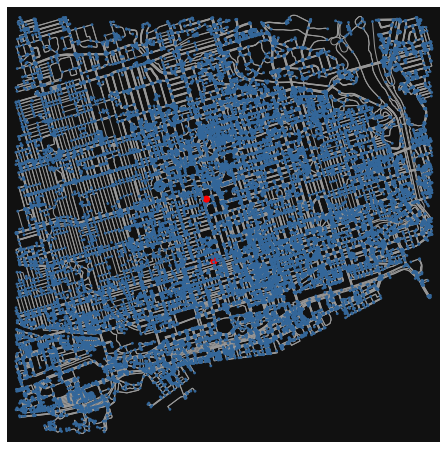

In [37]:
#Start of ACO

reference = (43.654589, -79.389229)

G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=(od_nodes.index)[0])
destination = Node(graph=G, osmid=(od_nodes.index)[1])

highlighted = [(od_nodes.index)[1], (od_nodes.index)[0]]

# marking both the source and destination node

nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [38]:
# Cost as length + complexity of route
def turns(G,route3):
    roads = []
    for i in range(0,len(route3)-1):
        way =G[route3[i]][route3[i+1]]
        roads.append(str(way[0]['osmid']))
    roads = len(set(roads))
    turn = roads -1
    return turn

# Initialize the parameter
updating_route = []
# Alpha and Beta are used in the pheremone calculation
alpha = 2
beta = 2

n = 200
Q = 1 # factor for post-route pheremone increase

pheremone_concentrations = dict()
known_routes = dict()

# randomize the pheromones
pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}


In [39]:
# a function to calculate pheremone levels
def pheremone(level, distance, alpha, beta):
    return level ** alpha * ((1/distance)) ** beta

In [40]:
for ant in tqdm(range(n)):
    # Place the ant at the colony
    frontier = [origin]
    explored = set()
    route = []
    found = False

    while frontier and not found:
        parent = frontier.pop(0)
        explored.add(parent)

        children = []
        children_pheremones = []
        for child in parent.expand():
            # If we see the destination, ignore all pheremones
            if child == destination:
                found = True
                route = child.path()
                continue
            if child not in explored:
                children.append(child)
                children_pheremones.append(
                    pheremone(
                        pheremone_concentrations[(parent.osmid, child.osmid)],
                        child.distance,
                        alpha,
                        beta,
                    )
                )

        if len(children) == 0:
            continue  # The ant is stuck, go back.

        transition_probability = [
            children_pheremones[i] / sum(children_pheremones)
            for i in range(len(children_pheremones))
        ]

        # Probabilistically choose a child to explore based weighted by transition probability
        chosen = random.choices(children, weights=transition_probability, k=1)[0]

        # Add all the non-explored children in case we need to explore them later
        children.pop(children.index(chosen))
        frontier.extend(children)

        # Set the chosen child to be the next node to explore
        frontier.insert(0, chosen)
    
    # We now have a completed route, we can increase pheremone levels 
    # on that route for the next ant to detect.

    for u, v in zip(route[:-1], route[1:]):
        length_of_edge = G[u][v][0]['length']
        pheremone_concentrations[(u,v)] += Q/length_of_edge
    
    # If the route is newly discovered, add it to the list
    route = tuple(route)
    updating_route.append(route)
    
    if route in known_routes:
        known_routes[route] += 1
    else:
        known_routes[route] = 1

  0%|          | 0/200 [00:00<?, ?it/s]

In [41]:
best_route = max(known_routes, key=known_routes.get)
times_used = known_routes[best_route]

route = list(best_route)
print("Times used:",times_used)
print("Cost:", cost(G,route))
print("Number of turns:",turns(G,route))
print("Route:",route)
first_route = route

Times used: 106
Cost: 1134.573
Number of turns: 25
Route: [2689723344, 2689723343, 2689723337, 2689723336, 3057655455, 3057655454, 3057655451, 3057655452, 773497109, 394502547, 34936037, 207713514, 394502555, 966509312, 966509310, 29604750, 394502553, 773498299, 1550990235, 1550990236, 393551252, 394502550, 394512440, 29696843, 394512460, 394512458, 393552059, 42606712, 6378746413, 6403166312, 394512452, 52926109, 394512446, 3716199878, 42606680, 6327999277, 6327999279, 42606691, 536328959, 406080393]


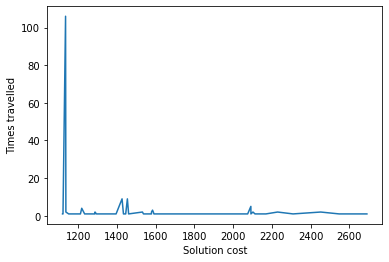

In [42]:
costs = [cost(G,r) for r in known_routes]
used = list(known_routes.values())

costs, used = zip(*sorted(zip(costs,used)))

plt.plot(costs, used)
plt.xlabel('Solution cost')
plt.ylabel('Times travelled')
plt.show()

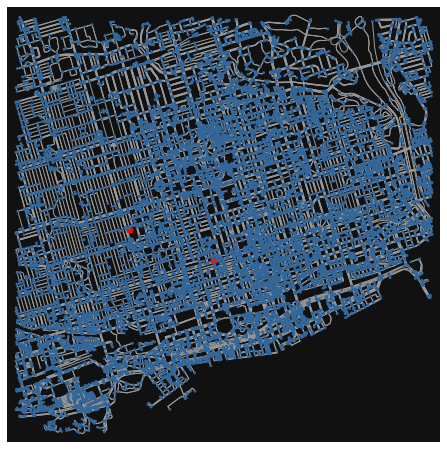

  0%|          | 0/500 [00:00<?, ?it/s]

In [43]:
if flag==1:
    reference = (43.654589, -79.389229)

    G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

    origin = Node(graph=G, osmid=(od_nodes_2.index)[0])
    destination = Node(graph=G, osmid=(od_nodes.index)[1])

    highlighted = [(od_nodes.index)[1], (od_nodes_2.index)[0]]

    # marking both the source and destination node

    nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
    ns = [50 if node in highlighted else 8 for node in G.nodes()]
    fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
    
    # Initialize the parameter

    # Alpha and Beta are used in the pheremone calculation
    alpha = 2
    beta = 5

    n = 500
    Q = 0.5 # factor for post-route pheremone increase

    pheremone_concentrations = dict()
    known_routes = dict()

    # randomize the pheromones
    pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}
    
    for ant in tqdm(range(n)):
        # Place the ant at the colony
        frontier = [origin]
        explored = set()
        route = []
        found = False

        while frontier and not found:
            parent = frontier.pop(0)
            explored.add(parent)

            children = []
            children_pheremones = []
            for child in parent.expand():
                # If we see the destination, ignore all pheremones
                if child == destination:
                    found = True
                    route1 = child.path()
                    continue
                if child not in explored:
                    children.append(child)
                    children_pheremones.append(
                        pheremone(
                            pheremone_concentrations[(parent.osmid, child.osmid)],
                            child.distance,
                            alpha,
                            beta,
                        )
                    )

            if len(children) == 0:
                continue  # The ant is stuck, go back.

            transition_probability = [
                children_pheremones[i] / sum(children_pheremones)
                for i in range(len(children_pheremones))
            ]

            # Probabilistically choose a child to explore based weighted by transition probability
            chosen = random.choices(children, weights=transition_probability, k=1)[0]

            # Add all the non-explored children in case we need to explore them later
            children.pop(children.index(chosen))
            frontier.extend(children)

            # Set the chosen child to be the next node to explore
            frontier.insert(0, chosen)

        # We now have a completed route, we can increase pheremone levels 
        # on that route for the next ant to detect.

        for u, v in zip(route[:-1], route[1:]):
            length_of_edge = G[u][v][0]['length']
            pheremone_concentrations[(u,v)] += Q/length_of_edge

        # If the route is newly discovered, add it to the list
        route1 = tuple(route1)
        if route1 in known_routes:
            known_routes[route1] += 1
        else:
            known_routes[route1] = 1
            
    best_route = max(known_routes, key=known_routes.get)
    times_used = known_routes[best_route]


In [44]:
if flag==1:
    route1 = list(best_route)
    print("Cost:", cost(G,route1))
    print("Times used:",times_used)
    print("Route:",route1)
    second_route= route1
    print("second_route----->",second_route)

Cost: 2235.77
Times used: 1
Route: [2415345694, 2415345705, 2415345710, 8961875765, 6369148137, 6369148307, 6369148306, 401526124, 5264034177, 401526123, 21631723, 393551231, 5264034174, 393551232, 401526130, 401526131, 393552095, 5264034179, 5264034180, 4857042879, 4857042878, 6369147788, 4857042882, 515621611, 515621610, 6369148337, 6369148334, 4597216750, 29696871, 401526133, 6369148333, 6369142347, 2486983155, 2486983157, 2486983161, 2486983151, 29696932, 29696875, 286265679, 7526363401, 286265537, 29696675, 3207015696, 3207015695, 249406183, 262699061, 393551180, 6375005441, 393551179, 393551178, 29696967, 393547034, 23922863, 32547802, 393546185, 6433351317, 393547025, 6433351139, 6380973904, 6433351138, 6433351137, 6433351136, 6433351135, 6433351134, 401522104, 401522105, 29689774, 401522124, 401522123, 406080391, 406080388, 1550992510, 393546122, 406080393]
second_route-----> [2415345694, 2415345705, 2415345710, 8961875765, 6369148137, 6369148307, 6369148306, 401526124, 5264034

In [45]:
if flag==1:
    second_route.reverse()

##### Visualization of the routes

In [46]:
reference = (43.654589, -79.389229)

G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)
final_route = first_route
if flag==1:
    final_route = first_route+second_route
long = [] 
lat = []  
for i in final_route:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])
# adding the lines joining the nodes
fig = go.Figure(go.Scattermapbox(
    name = "Path",
    mode = "lines",
    lon = long,
    lat = lat,
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'blue')))
# adding source marker
fig.add_trace(go.Scattermapbox(
    name = "Emergency Vehicle 1",
    mode = "markers",
    lon = [origin_lng1],
    lat = [origin_lat1],
    marker = {'size': 12, 'color':"red"}))
if flag==1:
    fig.add_trace(go.Scattermapbox(
        name = "Emergency Vehicle 2",
        mode = "markers",
        lon = [origin_lng2],
        lat = [origin_lat2],
        marker = {'size': 12, 'color':"yellow"}))

# adding destination marker
fig.add_trace(go.Scattermapbox(
    name = "Destination",
    mode = "markers",
    lon = [destination_lng1],
    lat = [destination_lat1],
    marker = {'size': 12, 'color':'green'}))

# getting center for plots:
lat_center = np.mean(lat)
long_center = np.mean(long)
# defining the layout using mapbox_style
fig.update_layout(mapbox_style="stamen-terrain",
    mapbox_center_lat = 30, mapbox_center_lon=-80)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  mapbox = {
                      'center': {'lat': lat_center, 
                      'lon': long_center},
                      'zoom': 13})
fig.show()

## Firefly Algorithm

The initial population of fireflies is set to 100 and are randomly positioned. Here the attractiveness factor is calculated based on the cost and complexity of the route of each firefly. The firefly with minimum cost and complexity is considered luminous. The complexity refers to the number of turns involved in the route of the firefly towards the destination.   
The state of the population is analyzed for various iterations and the final minimum cost is considered. The number of iterations is set initially. The number of iterations and gamma value are set to obtain the optimal solution. Gamma value refers to the attraction coefficient which is used to calculate the luminosity level of the fireflies.  
The luminosity is set as an function of distance and is caluclated using the formula:  
$
   luminosity_{i} \leftarrow luminosity_{j} * e^{(\gamma ^*distance)}
$


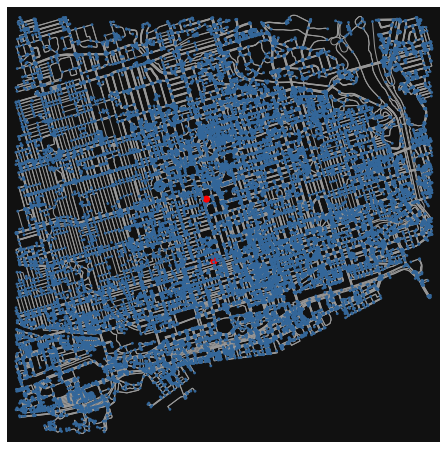

In [47]:
import osmnx
from smart_mobility_utilities.common import Node, cost, randomized_search
from smart_mobility_utilities.viz import draw_route
from smart_mobility_utilities.problem import cross_over
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
#Firefly alogrithm

reference = (43.654589, -79.389229)

# The simplify=True is critical, as it removes non-important nodes
G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

origin = Node(graph=G, osmid=(od_nodes.index)[0])
destination = Node(graph=G, osmid=(od_nodes.index)[1])

highlighted = [(od_nodes.index)[1], (od_nodes.index)[0]]

# marking both the source and destination node

nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
ns = [50 if node in highlighted else 8 for node in G.nodes()]
fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

In [48]:
# Cost as length + complexity of route
def turns(G,route):
    roads = []
    for i in range(0,len(route)-1):
        way =G[route[i]][route[i+1]]
        roads.append(str(way[0]['osmid']))
    roads = len(set(roads))
    turn = roads -1
    return turn

def luminosity(G, route, k=1):
    
    return cost(G,route) + k*turns(G,route)

# Define the distance between two routes as the number of common nodes they possess
def distance(route1,route2):
    return len(set(route1) & set(route2))

In [49]:
# Initialize some parameters
num_of_iterations = 15
pop_size = 100
gamma = 2 # coefficient of attractiveness
k = 100 # weight for complexity, essentially how many metres does it cost per node

# Initialize starting population
flies = [randomized_search(G,origin.osmid, destination.osmid) for _ in range(pop_size)]

# Track performance
states= []

In [50]:
for _ in tqdm(range(num_of_iterations)):
    for i in range(pop_size):
        flies_luminosity = list()  # for all flies except i
        for j in range(pop_size):
            if i == j:
                continue
            flies_luminosity.append((j, luminosity(G, flies[j],k)))
        moving_fly = flies[i]
        # Using min here as the "most" luminous is the one with lowest cost + complexity
        target_fly = min(
            flies_luminosity,
            key=lambda fly: fly[1]
            * math.exp(-1 * gamma * distance(moving_fly, flies[fly[0]]))
        )
        target_fly = flies[target_fly[0]]
        # update the position, moving is just a crossover
        flies[i] = cross_over(target_fly,moving_fly)
    states.append(sum([luminosity(G,x,k) for x in flies]))

  0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
# Most luminous fly
route = min(flies, key=lambda fly: luminosity(G,fly,k))
c = cost(G,route)
print("Cost:",c)
print("Number of turns:",turns(G,route))
print("Route:",route)
firefly_first_route = route
print("firefly_first_route:",firefly_first_route)

Cost: 1040.564
Number of turns: 10
Route: [2689723344, 2689723343, 2689723337, 2689723336, 3057655455, 3057655452, 773497109, 394502547, 773497110, 2702116127, 394502548, 394512460, 394512458, 2809038555, 6994226886, 6403166307, 6403166312, 394512452, 52926109, 394512446, 394512448, 536328961, 536328959, 406080393]
firefly_first_route: [2689723344, 2689723343, 2689723337, 2689723336, 3057655455, 3057655452, 773497109, 394502547, 773497110, 2702116127, 394502548, 394512460, 394512458, 2809038555, 6994226886, 6403166307, 6403166312, 394512452, 52926109, 394512446, 394512448, 536328961, 536328959, 406080393]


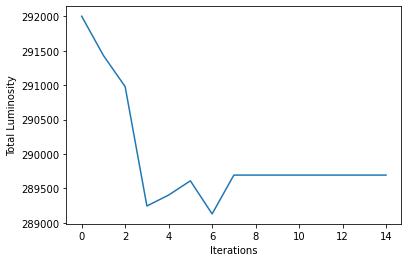

In [52]:
ax = plt.plot(states)
plt.xlabel('Iterations')
plt.ylabel('Total Luminosity')
plt.show()

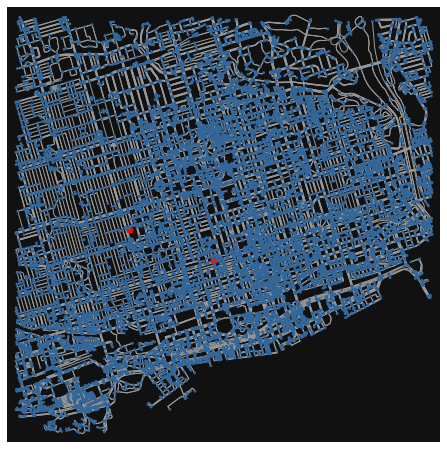

  0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
if flag==1:
    reference = (43.654589, -79.389229)

    # The simplify=True is critical, as it removes non-important nodes
    G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

    origin = Node(graph=G, osmid=(od_nodes_2.index)[0])
    destination = Node(graph=G, osmid=(od_nodes.index)[1])

    highlighted = [(od_nodes.index)[1], (od_nodes_2.index)[0]]

    # marking both the source and destination node

    nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
    ns = [50 if node in highlighted else 8 for node in G.nodes()]
    fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
    
    # Cost as length + complexity of route
    def turns(G,route):
        roads = []
        for i in range(0,len(route)-1):
            way =G[route[i]][route[i+1]]
            roads.append(str(way[0]['osmid']))
        roads = len(set(roads))
        turn = roads -1
        return turn

    def luminosity(G, route, k=1):
    
        return cost(G,route) + k*turns(G,route)

    # Define the distance between two routes as the number of common nodes they possess
    def distance(route1,route2):
        return len(set(route1) & set(route2))
    
    # Initialize some parameters
    num_of_iterations = 15
    pop_size = 100
    gamma = 2 # coefficient of attractiveness
    k = 100 # weight for complexity, essentially how many metres does it cost per node

    # Initialize starting population
    flies = [randomized_search(G,origin.osmid, destination.osmid) for _ in range(pop_size)]

    # Track performance
    states= []
    
    for _ in tqdm(range(num_of_iterations)):
        for i in range(pop_size):
            flies_luminosity = list()  # for all flies except i
            for j in range(pop_size):
                if i == j:
                    continue
                flies_luminosity.append((j, luminosity(G, flies[j],k)))
            moving_fly = flies[i]
            # Using min here as the "most" luminous is the one with lowest cost + complexity
            target_fly = min(
                flies_luminosity,
                key=lambda fly: fly[1]
                * math.exp(-1 * gamma * distance(moving_fly, flies[fly[0]]))
            )
            target_fly = flies[target_fly[0]]
            # update the position, moving is just a crossover
            flies[i] = cross_over(target_fly,moving_fly)
        states.append(sum([luminosity(G,x,k) for x in flies]))

In [54]:
if flag==1:
    # Most luminous fly
    route = min(flies, key=lambda fly: luminosity(G,fly,k))
    c = cost(G,route)
    print("Cost:",c)
    print("Number of turns:",turns(G,route))
    print("Route:",route)
    firefly_second_route = route

Cost: 2148.967
Number of turns: 22
Route: [2415345694, 2415345705, 2415345710, 8961875765, 6369148137, 2415345619, 2415345615, 393551231, 21631723, 393552095, 4857042882, 515621611, 2415345493, 54965550, 4597216750, 6369148333, 401526133, 249406258, 2486983149, 4597211458, 2486983151, 29696932, 29696875, 262698794, 262698301, 262698271, 8870800400, 262699113, 393551179, 393551178, 6375005530, 393547034, 23922863, 32547802, 393546185, 29696868, 393547024, 401525279, 29696869, 6400941849, 966500406, 393546184, 29696862, 29696858, 406080388, 1550992510, 406080392, 406080393]


In [55]:
if flag==1:
    firefly_second_route.reverse()

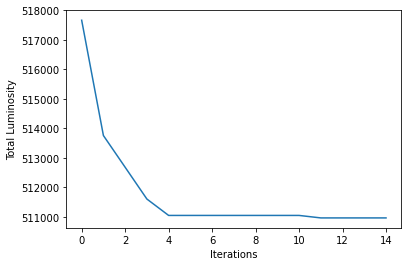

In [56]:
if flag==1:
    ax = plt.plot(states)
    plt.xlabel('Iterations')
    plt.ylabel('Total Luminosity')
    plt.show()

##### Visualization of the routes

In [57]:
reference = (43.654589, -79.389229)

G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)
final_route_firefly = firefly_first_route
if flag==1:
    final_route_firefly = firefly_first_route + firefly_second_route
long = [] 
lat = []  
for i in final_route_firefly:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])
# adding the lines joining the nodes
fig = go.Figure(go.Scattermapbox(
    name = "Path",
    mode = "lines",
    lon = long,
    lat = lat,
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'blue')))
# adding source marker
fig.add_trace(go.Scattermapbox(
    name = "Emergency Vehicle 1",
    mode = "markers",
    lon = [origin_lng1],
    lat = [origin_lat1],
    marker = {'size': 12, 'color':"red"}))
if flag==1:
    fig.add_trace(go.Scattermapbox(
        name = "Emergency vehicle 2",
        mode = "markers",
        lon = [origin_lng2],
        lat = [origin_lat2],
        marker = {'size': 12, 'color':"yellow"}))

# adding destination marker
fig.add_trace(go.Scattermapbox(
    name = "Destination",
    mode = "markers",
    lon = [destination_lng1],
    lat = [destination_lat1],
    marker = {'size': 12, 'color':'green'}))

# getting center for plots:
lat_center = np.mean(lat)
long_center = np.mean(long)
# defining the layout using mapbox_style
fig.update_layout(mapbox_style="stamen-terrain",
    mapbox_center_lat = 30, mapbox_center_lon=-80)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  mapbox = {
                      'center': {'lat': lat_center, 
                      'lon': long_center},
                      'zoom': 13})
fig.show()

## Adaptive Ant Colony Optimation (ACO + GA)

In adaptive ACO, We use Genetic Algorithm to tune the parameters α and β in ACO to get better result. General steps for adaptive ACO can be described as followed:  

### Initialize

First we set generation number to be 5, and the number of solution in each generation is 8.

### Fitness

 Each individual in generation can get an ACO cost, that is what we use as fitness to choose minimal 4 individuals as parents. This can be described as:  
$$parents= \mathop {min}(ACO(individuals))$$

### Crossover

The crossover process is dividing individuals into two halves(head and tail) and select them to form new individuals in a ring sequence.

### Mutation

We apply some mutation to the second value. The principle is to add a random value.

In [58]:
#adaptive ACO STart
# a function to calculate pheremone levels
def pheremone(level, distance, alpha, beta):
    return level ** alpha * ((1/distance)) ** beta
# Initialize the parameter
def ACO(data):
    reference = (43.654589, -79.389229)

    G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

    origin = Node(graph=G, osmid=(od_nodes.index)[0])
    destination = Node(graph=G, osmid=(od_nodes.index)[1])

    highlighted = [(od_nodes.index)[1], (od_nodes.index)[0]]

    # marking both the source and destination node

    nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
    ns = [50 if node in highlighted else 8 for node in G.nodes()]
#     fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
    # Alpha and Beta are used in the pheremone calculation
    alpha = data[0]
    beta = data[1]
    n = 200
    Q = 1 # factor for post-route pheremone increase
    print(alpha)
    print(beta)

    pheremone_concentrations = dict()
    known_routes = dict()

    # randomize the pheromones
    pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}

    for ant in tqdm(range(n)):
        # Place the ant at the colony
        frontier = [origin]
        explored = set()
        found = False

        while frontier and not found:
            parent = frontier.pop(0)
            explored.add(parent)

            children = []
            children_pheremones = []
            for child in parent.expand():
                # If we see the destination, ignore all pheremones
                if child == destination:
                    found = True
                    route = child.path()
                    continue
                if child not in explored:
                    children.append(child)
                    children_pheremones.append(
                        pheremone(
                            pheremone_concentrations[(parent.osmid, child.osmid)],
                            child.distance,
                            alpha,
                            beta,
                        )
                    )

            if len(children) == 0:
                continue  # The ant is stuck, go back.

            transition_probability = [
                children_pheremones[i] / sum(children_pheremones)
                for i in range(len(children_pheremones))
            ]

            # Probabilistically choose a child to explore based weighted by transition probability
            chosen = random.choices(children, weights=transition_probability, k=1)[0]

            # Add all the non-explored children in case we need to explore them later
            children.pop(children.index(chosen))
            frontier.extend(children)

            # Set the chosen child to be the next node to explore
            frontier.insert(0, chosen)

        # We now have a completed route, we can increase pheremone levels 
        # on that route for the next ant to detect.

        for u, v in zip(route[:-1], route[1:]):
            length_of_edge = G[u][v][0]['length']
            pheremone_concentrations[(u,v)] += Q/length_of_edge

        # If the route is newly discovered, add it to the list
        route = tuple(route)
        if route in known_routes:
            known_routes[route] += 1
        else:
            known_routes[route] = 1
    best_route = max(known_routes, key=known_routes.get)
    times_used = known_routes[best_route]
    mon = cost(G,route)
    return mon

#----------------------------------------------------------------------------------------------------

def resultACO(data):
    reference = (43.654589, -79.389229)

    G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

    origin = Node(graph=G, osmid=(od_nodes.index)[0])
    destination = Node(graph=G, osmid=(od_nodes.index)[1])

    highlighted = [(od_nodes.index)[1], (od_nodes.index)[0]]

    # marking both the source and destination node

    nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
    ns = [50 if node in highlighted else 8 for node in G.nodes()]
#     fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
    # Alpha and Beta are used in the pheremone calculation
    alpha = data[0]
    beta = data[1]
    n = 500
    Q = 1 # factor for post-route pheremone increase
    print(alpha)
    print(beta)

    pheremone_concentrations = dict()
    known_routes = dict()

    # randomize the pheromones
    pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}

    for ant in tqdm(range(n)):
        # Place the ant at the colony
        frontier = [origin]
        explored = set()
        found = False

        while frontier and not found:
            parent = frontier.pop(0)
            explored.add(parent)

            children = []
            children_pheremones = []
            for child in parent.expand():
                # If we see the destination, ignore all pheremones
                if child == destination:
                    found = True
                    route = child.path()
                    continue
                if child not in explored:
                    children.append(child)
                    children_pheremones.append(
                        pheremone(
                            pheremone_concentrations[(parent.osmid, child.osmid)],
                            child.distance,
                            alpha,
                            beta,
                        )
                    )

            if len(children) == 0:
                continue  # The ant is stuck, go back.

            transition_probability = [
                children_pheremones[i] / sum(children_pheremones)
                for i in range(len(children_pheremones))
            ]

            # Probabilistically choose a child to explore based weighted by transition probability
            chosen = random.choices(children, weights=transition_probability, k=1)[0]

            # Add all the non-explored children in case we need to explore them later
            children.pop(children.index(chosen))
            frontier.extend(children)

            # Set the chosen child to be the next node to explore
            frontier.insert(0, chosen)

        # We now have a completed route, we can increase pheremone levels 
        # on that route for the next ant to detect.

        for u, v in zip(route[:-1], route[1:]):
            length_of_edge = G[u][v][0]['length']
            pheremone_concentrations[(u,v)] += Q/length_of_edge

        # If the route is newly discovered, add it to the list
        route = tuple(route)
        if route in known_routes:
            known_routes[route] += 1
        else:
            known_routes[route] = 1
    best_route = max(known_routes, key=known_routes.get)
    times_used = known_routes[best_route]
    mon = cost(G,route)
    return best_route,mon


#--------------------------------------------------------------------------------------------------

num_weights = 2
sol_per_pop = 8    
pop_size = (sol_per_pop,num_weights)
new_population = numpy.random.randint(low=1, high=4.0, size=pop_size)
num_generations = 5
num_parents_mating = 4
def select_mating_pool(pop, fitness, num_parents):
    parents = numpy.empty((num_parents, pop.shape[1]))

    for parent_num in range(num_parents):

        min_fitness_idx = numpy.where(fitness == numpy.min(fitness))

        min_fitness_idx = min_fitness_idx[0][0]

        parents[parent_num, :] = pop[min_fitness_idx, :]

        fitness[min_fitness_idx] = 99999999999

    return parents
    
def crossover(parents, offspring_size):
    offspring = numpy.empty(offspring_size)
     # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)
 
    for k in range(offspring_size[0]):
         # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
         # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
         # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
         # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover):

    # Mutation changes a single gene in each offspring randomly.

    for idx in range(offspring_crossover.shape[0]):

        # The random value to be added to the gene.

        random_value = numpy.random.randint(1, 4, 1)

        offspring_crossover[idx, 1] = offspring_crossover[idx, 1] + random_value

    return offspring_crossover

for generation in range(num_generations):
     # Measuring the fitness of each chromosome in the population.
    fitness = []
    for i in range(len(new_population)):
        fitness1 = ACO(new_population[i])
        fitness.append(fitness1)
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, 
                                       num_parents_mating)
 
     # Generating next generation using crossover.
    offspring_crossover = crossover(parents,
                                        offspring_size=(pop_size[0]-parents.shape[0], num_weights))
 
     # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)
# Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

fitness = []
for i in range(len(new_population)):
    print(new_population)
    fitness1 = ACO(new_population[i])
    print("11:", fitness1)
    fitness.append(fitness1)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = fitness.index(numpy.min(fitness))

print("Best solution : ", new_population[best_match_idx])
print("Best solution fitness : ", fitness[best_match_idx])
best_route,cost = resultACO(new_population[best_match_idx])
print("best_route",best_route)
print("Cost:", cost)
first_route_adaptive_aco = list(best_route)

3
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
1


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

3
2


  0%|          | 0/200 [00:00<?, ?it/s]

2
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

3
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
1


  0%|          | 0/200 [00:00<?, ?it/s]

3
4


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
7


  0%|          | 0/200 [00:00<?, ?it/s]

2
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
7


  0%|          | 0/200 [00:00<?, ?it/s]

2
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
10


  0%|          | 0/200 [00:00<?, ?it/s]

1
7


  0%|          | 0/200 [00:00<?, ?it/s]

2
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
6


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
8


  0%|          | 0/200 [00:00<?, ?it/s]

2
6


  0%|          | 0/200 [00:00<?, ?it/s]

[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
2
4


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1539.775
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
8


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1813.337
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
6


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1788.755
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
3


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1645.749
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
2
11


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2305.24
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
8


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1820.736
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
5


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1432.848
[[ 2  4]
 [ 1  8]
 [ 1  6]
 [ 1  3]
 [ 2 11]
 [ 1  8]
 [ 1  5]
 [ 1  5]]
1
5


  0%|          | 0/200 [00:00<?, ?it/s]

11: 1417.052
Best solution :  [1 5]
Best solution fitness :  1417.052
1
5


  0%|          | 0/500 [00:00<?, ?it/s]

best_route (2689723344, 2689723343, 2689723340, 2689723337, 2689723336, 2689723335, 3057655454, 3057655455, 3057655452, 3057655451, 773495400, 773495375, 773495396, 835057395, 773497119, 29604703, 394502557, 773497139, 394502555, 207713514, 34936037, 966509310, 966509312, 773498306, 394502553, 773498299, 1550990235, 1550990236, 393551252, 394502550, 394512440, 29696843, 394512460, 394512458, 393552059, 42606712, 6378746413, 6403166312, 394512452, 52926109, 394512446, 3716199878, 42606680, 6327999277, 6327999279, 42606691, 536328959, 406080393)
Cost: 1133.773


In [59]:
if flag==1:
    import osmnx
    from smart_mobility_utilities.common import Node, cost
    from smart_mobility_utilities.viz import draw_route
    import random
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import math
    import numpy


    # a function to calculate pheremone levels
    def pheremone(level, distance, alpha, beta):
        return level ** alpha * ((1/distance)) ** beta
    # Initialize the parameter
    def ACO(data):
        reference = (43.654589, -79.389229)

        G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

        origin = Node(graph=G, osmid=(od_nodes_2.index)[0])
        destination = Node(graph=G, osmid=(od_nodes.index)[1])

        highlighted = [(od_nodes.index)[1], (od_nodes_2.index)[0]]


        # marking both the source and destination node

        nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
        ns = [50 if node in highlighted else 8 for node in G.nodes()]
    #     fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
        # Alpha and Beta are used in the pheremone calculation
        alpha = data[0]
        beta = data[1]
        n = 200
        Q = 1 # factor for post-route pheremone increase
        print(alpha)
        print(beta)

        pheremone_concentrations = dict()
        known_routes = dict()

        # randomize the pheromones
        pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}

        for ant in tqdm(range(n)):
            # Place the ant at the colony
            frontier = [origin]
            explored = set()
            found = False

            while frontier and not found:
                parent = frontier.pop(0)
                explored.add(parent)

                children = []
                children_pheremones = []
                for child in parent.expand():
                    # If we see the destination, ignore all pheremones
                    if child == destination:
                        found = True
                        route = child.path()
                        continue
                    if child not in explored:
                        children.append(child)
                        children_pheremones.append(
                            pheremone(
                                pheremone_concentrations[(parent.osmid, child.osmid)],
                                child.distance,
                                alpha,
                                beta,
                            )
                        )

                if len(children) == 0:
                    continue  # The ant is stuck, go back.

                transition_probability = [
                    children_pheremones[i] / sum(children_pheremones)
                    for i in range(len(children_pheremones))
                ]

                # Probabilistically choose a child to explore based weighted by transition probability
                chosen = random.choices(children, weights=transition_probability, k=1)[0]

                # Add all the non-explored children in case we need to explore them later
                children.pop(children.index(chosen))
                frontier.extend(children)

                # Set the chosen child to be the next node to explore
                frontier.insert(0, chosen)

            # We now have a completed route, we can increase pheremone levels 
            # on that route for the next ant to detect.

            for u, v in zip(route[:-1], route[1:]):
                length_of_edge = G[u][v][0]['length']
                pheremone_concentrations[(u,v)] += Q/length_of_edge

            # If the route is newly discovered, add it to the list
            route = tuple(route)
            if route in known_routes:
                known_routes[route] += 1
            else:
                known_routes[route] = 1
        best_route = max(known_routes, key=known_routes.get)
        times_used = known_routes[best_route]
        mon = cost(G,route)
        return mon

    #----------------------------------------------------------------------------------------------------

    def resultACO(data):
        reference = (43.654589, -79.389229)

        G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)

        origin = Node(graph=G, osmid=(od_nodes_2.index)[0])
        destination = Node(graph=G, osmid=(od_nodes.index)[1])

        highlighted = [(od_nodes.index)[1], (od_nodes_2.index)[0]]

        # marking both the source and destination node

        nc = ['red' if node in highlighted else '#336699' for node in G.nodes()]
        ns = [50 if node in highlighted else 8 for node in G.nodes()]
    #     fig, ax = osmnx.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)
        # Alpha and Beta are used in the pheremone calculation
        alpha = data[0]
        beta = data[1]
        n = 500
        Q = 1 # factor for post-route pheremone increase
        print(alpha)
        print(beta)

        pheremone_concentrations = dict()
        known_routes = dict()

        # randomize the pheromones
        pheremone_concentrations = {(u,v):random.uniform(0,0.5) for [u,v] in G.edges()}

        for ant in tqdm(range(n)):
            # Place the ant at the colony
            frontier = [origin]
            explored = set()
            found = False

            while frontier and not found:
                parent = frontier.pop(0)
                explored.add(parent)

                children = []
                children_pheremones = []
                for child in parent.expand():
                    # If we see the destination, ignore all pheremones
                    if child == destination:
                        found = True
                        route = child.path()
                        continue
                    if child not in explored:
                        children.append(child)
                        children_pheremones.append(
                            pheremone(
                                pheremone_concentrations[(parent.osmid, child.osmid)],
                                child.distance,
                                alpha,
                                beta,
                            )
                        )

                if len(children) == 0:
                    continue  # The ant is stuck, go back.

                transition_probability = [
                    children_pheremones[i] / sum(children_pheremones)
                    for i in range(len(children_pheremones))
                ]

                # Probabilistically choose a child to explore based weighted by transition probability
                chosen = random.choices(children, weights=transition_probability, k=1)[0]

                # Add all the non-explored children in case we need to explore them later
                children.pop(children.index(chosen))
                frontier.extend(children)

                # Set the chosen child to be the next node to explore
                frontier.insert(0, chosen)

            # We now have a completed route, we can increase pheremone levels 
            # on that route for the next ant to detect.

            for u, v in zip(route[:-1], route[1:]):
                length_of_edge = G[u][v][0]['length']
                pheremone_concentrations[(u,v)] += Q/length_of_edge

            # If the route is newly discovered, add it to the list
            route = tuple(route)
            if route in known_routes:
                known_routes[route] += 1
            else:
                known_routes[route] = 1
        best_route = max(known_routes, key=known_routes.get)
        times_used = known_routes[best_route]
        mon = cost(G,route)
        return best_route,mon


    #--------------------------------------------------------------------------------------------------

    num_weights = 2
    sol_per_pop = 8    
    pop_size = (sol_per_pop,num_weights)
    new_population = numpy.random.randint(low=1, high=4.0, size=pop_size)
    num_generations = 5
    num_parents_mating = 4
    def select_mating_pool(pop, fitness, num_parents):
        parents = numpy.empty((num_parents, pop.shape[1]))

        for parent_num in range(num_parents):

            min_fitness_idx = numpy.where(fitness == numpy.min(fitness))

            min_fitness_idx = min_fitness_idx[0][0]

            parents[parent_num, :] = pop[min_fitness_idx, :]

            fitness[min_fitness_idx] = 99999999999

        return parents

    def crossover(parents, offspring_size):
        offspring = numpy.empty(offspring_size)
         # The point at which crossover takes place between two parents. Usually, it is at the center.
        crossover_point = numpy.uint8(offspring_size[1]/2)

        for k in range(offspring_size[0]):
             # Index of the first parent to mate.
            parent1_idx = k%parents.shape[0]
             # Index of the second parent to mate.
            parent2_idx = (k+1)%parents.shape[0]
             # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
             # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

    def mutation(offspring_crossover):

        # Mutation changes a single gene in each offspring randomly.

        for idx in range(offspring_crossover.shape[0]):

            # The random value to be added to the gene.

            random_value = numpy.random.randint(1, 4, 1)

            offspring_crossover[idx, 1] = offspring_crossover[idx, 1] + random_value

        return offspring_crossover

    for generation in range(num_generations):
         # Measuring the fitness of each chromosome in the population.
        fitness = []
        for i in range(len(new_population)):
            fitness1 = ACO(new_population[i])
            fitness.append(fitness1)
        # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, 
                                           num_parents_mating)

         # Generating next generation using crossover.
        offspring_crossover = crossover(parents,
                                            offspring_size=(pop_size[0]-parents.shape[0], num_weights))

         # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover)
    # Creating the new population based on the parents and offspring.
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation

    fitness = []
    for i in range(len(new_population)):
        print(new_population)
        fitness1 = ACO(new_population[i])
        print("11:", fitness1)
        fitness.append(fitness1)
    # Then return the index of that solution corresponding to the best fitness.
    best_match_idx = fitness.index(numpy.min(fitness))

    print("Best solution : ", new_population[best_match_idx])
    print("Best solution fitness : ", fitness[best_match_idx])
    best_route,cost = resultACO(new_population[best_match_idx])
    print("best_route",best_route)
    route = list(best_route)
    print(route)
    print("Cost:", cost)
    # print("Times used:",times_used)
    # draw_route(G,route)
    second_route_adaptive_aco = list(best_route)

3
2


  0%|          | 0/200 [00:00<?, ?it/s]

3
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

2
1


  0%|          | 0/200 [00:00<?, ?it/s]

2
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

2
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

2
1


  0%|          | 0/200 [00:00<?, ?it/s]

1
5


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

2
4


  0%|          | 0/200 [00:00<?, ?it/s]

2
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
6


  0%|          | 0/200 [00:00<?, ?it/s]

2
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
7


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
2


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
6


  0%|          | 0/200 [00:00<?, ?it/s]

1
3


  0%|          | 0/200 [00:00<?, ?it/s]

1
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
7


  0%|          | 0/200 [00:00<?, ?it/s]

1
5


  0%|          | 0/200 [00:00<?, ?it/s]

1
4


  0%|          | 0/200 [00:00<?, ?it/s]

[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
2


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2240.583
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
5


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2535.418
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
3


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2740.353
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
4


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2063.457
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
7


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2194.408
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
4


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2951.287
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
6


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2359.801
[[1 2]
 [1 5]
 [1 3]
 [1 4]
 [1 7]
 [1 4]
 [1 6]
 [1 5]]
1
5


  0%|          | 0/200 [00:00<?, ?it/s]

11: 2497.761
Best solution :  [1 4]
Best solution fitness :  2063.457
1
4


  0%|          | 0/500 [00:00<?, ?it/s]

best_route (2415345694, 2415345705, 2415345710, 8961875765, 6369148137, 2415345619, 2415345615, 393551231, 5264034174, 393551232, 401526130, 21631723, 393552095, 5264034179, 5264034180, 4857042879, 4857042878, 6369147788, 4857042882, 515621611, 515621610, 6369148337, 6369148334, 4597216750, 29696871, 401526133, 6369148333, 6369142347, 2486983155, 2486983157, 2486983161, 2486983151, 4597211458, 2486983149, 249406258, 249406188, 249406184, 249406257, 29696674, 286265472, 29696675, 249406229, 29696676, 3207015698, 3207015697, 262699061, 393551180, 6375005441, 3207015674, 29696960, 393551193, 6375005440, 393551192, 262702412, 29696965, 393551179, 262699113, 262699117, 4407451158, 393551178, 29696967, 393547034, 23922863, 393551190, 6375005501, 393546187, 32547802, 393546185, 6433351317, 393547025, 6433351139, 6380973904, 6433351138, 6433351137, 6433351136, 6433351135, 6433351134, 401522104, 401522105, 401522106, 6283001332, 393546186, 401522123, 401522124, 401522125, 401525277, 6433351133,

In [60]:
if flag==1:
    second_route_adaptive_aco.reverse()

##### Visualization of the routes

In [61]:
reference = (43.654589, -79.389229)

G = osmnx.graph_from_point(reference, dist=3000, clean_periphery=True, simplify=True)
final_route_adpative_aco = first_route_adaptive_aco
if flag==1:
    final_route_adpative_aco = first_route_adaptive_aco + second_route_adaptive_aco
print(final_route_adpative_aco)
long = [] 
lat = []  
for i in final_route_adpative_aco:
     point = G.nodes[i]
     long.append(point['x'])
     lat.append(point['y'])
# adding the lines joining the nodes
fig = go.Figure(go.Scattermapbox(
    name = "Path",
    mode = "lines",
    lon = long,
    lat = lat,
    marker = {'size': 10},
    line = dict(width = 4.5, color = 'blue')))
# adding source marker
fig.add_trace(go.Scattermapbox(
    name = "Emergency Vehicle 1",
    mode = "markers",
    lon = [origin_lng1],
    lat = [origin_lat1],
    marker = {'size': 12, 'color':"red"}))
if flag==1:
    fig.add_trace(go.Scattermapbox(
        name = "Emergency Vehicle 2",
        mode = "markers",
        lon = [origin_lng2],
        lat = [origin_lat2],
        marker = {'size': 12, 'color':"yellow"}))

# adding destination marker
fig.add_trace(go.Scattermapbox(
    name = "Destination",
    mode = "markers",
    lon = [destination_lng1],
    lat = [destination_lat1],
    marker = {'size': 12, 'color':'green'}))

# getting center for plots:
lat_center = np.mean(lat)
long_center = np.mean(long)
# defining the layout using mapbox_style
fig.update_layout(mapbox_style="stamen-terrain",
    mapbox_center_lat = 30, mapbox_center_lon=-80)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                  mapbox = {
                      'center': {'lat': lat_center, 
                      'lon': long_center},
                      'zoom': 13})
fig.show()

[2689723344, 2689723343, 2689723340, 2689723337, 2689723336, 2689723335, 3057655454, 3057655455, 3057655452, 3057655451, 773495400, 773495375, 773495396, 835057395, 773497119, 29604703, 394502557, 773497139, 394502555, 207713514, 34936037, 966509310, 966509312, 773498306, 394502553, 773498299, 1550990235, 1550990236, 393551252, 394502550, 394512440, 29696843, 394512460, 394512458, 393552059, 42606712, 6378746413, 6403166312, 394512452, 52926109, 394512446, 3716199878, 42606680, 6327999277, 6327999279, 42606691, 536328959, 406080393, 406080393, 393546122, 406080387, 394502536, 393546124, 394502535, 6433351325, 6283001331, 401525285, 393546184, 966500406, 966500402, 401525287, 6283001319, 6283001320, 6283001346, 401525309, 401525310, 29696866, 29696860, 401525281, 401525299, 401525301, 29696869, 6400941849, 6400941848, 6433351133, 401525277, 401522125, 401522124, 401522123, 393546186, 6283001332, 401522106, 401522105, 401522104, 6433351134, 6433351135, 6433351136, 6433351137, 6433351138,